In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline


<module 'ccg_layer' from '/Users/xiaoxuanj/work/work_allen/Ephys/code_library/ephys_code/ccg_layer.pyc'>

In [ ]:
def load_npz(filename):
    """
    load npz files with sparse matrix and dimension
    output dense matrix with the correct dim
    """
    npzfile = np.load(filename, allow_pickle=True) 
    sparse_matrix = npzfile['arr_0'][0]
    ndim=npzfile['arr_0'][1]

    new_matrix_2d = np.array(sparse_matrix.todense())
    new_matrix = new_matrix_2d.reshape(ndim)
    return new_matrix

In [2]:
color_bank = {'probeA':'r',
             'probeB':'brown',
             'probeC': '#E3CF57',
             'probeD': 'green',
             'probeE': 'purple',
             'probeF': 'blue'}
colors = ['#E3CF57', 'green', 'purple', 'blue', 'brown', 'r', 'b','g','gray']

probe_area={'probeA':'AM',
             'probeB':'PM',
             'probeC': 'V1',
             'probeD': 'LM',
             'probeE': 'AL',
             'probeF': 'RL'}

#areas_all = ['LGd','VISp','VISl', 'VISrl', 'VISal', 'VISpm', 'VISam',  'LP']
areas_all = ['VISp','VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']



# group sharp peak to areas 

412804
2002
412809
3778
415149
2234
416356
1302
416357
1432
416861
1494
419112
2152
419114
2289
419116
1925
419117
1168
419118
1892
419119
2152
424445
1998
434488
1914
437661
4234
448503
3939
433891
1185
432105
1433
432104
1315
437660
1403
429857
1525
434494
1652
425597
1457
415148
8965
418196
2034


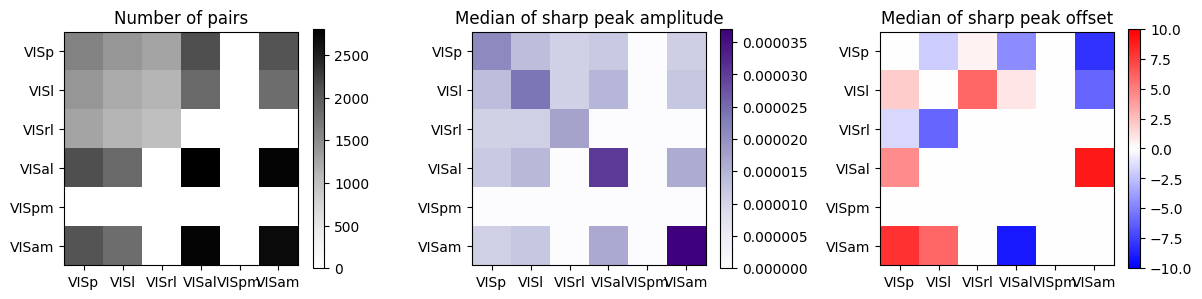

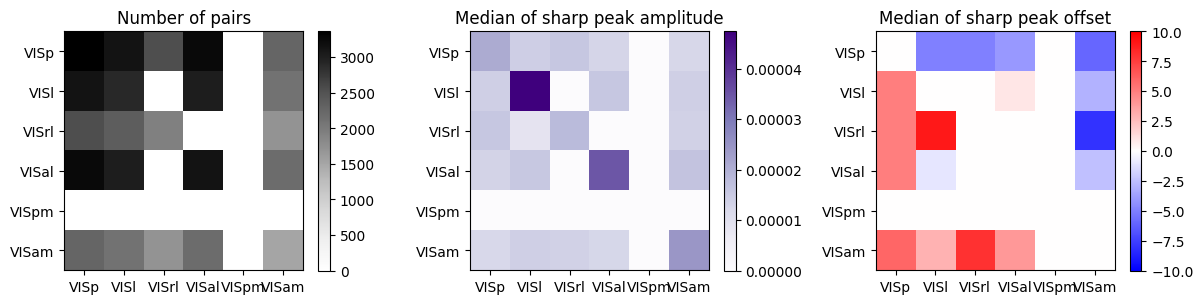

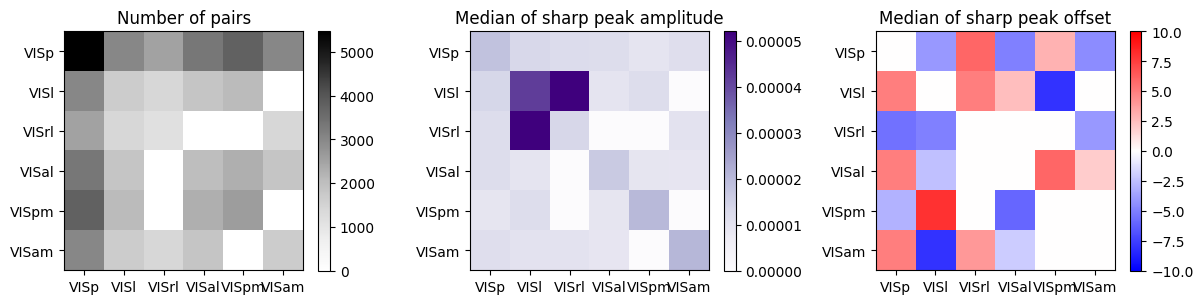

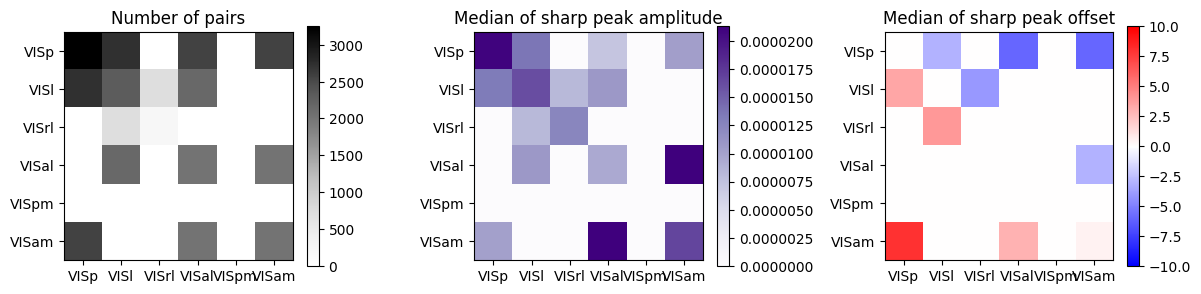

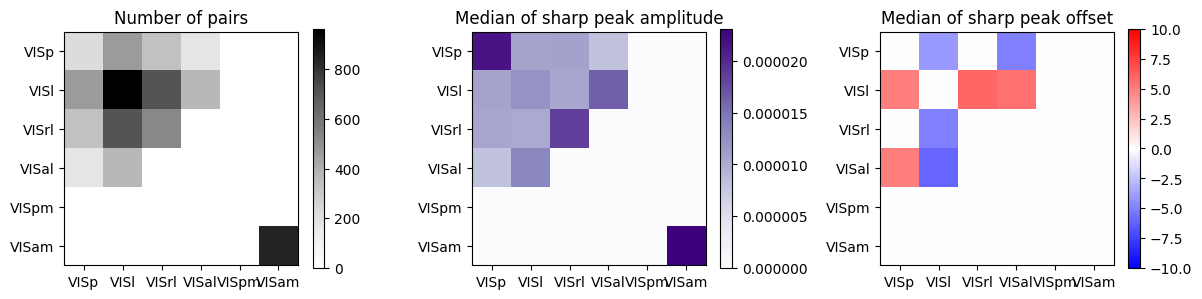

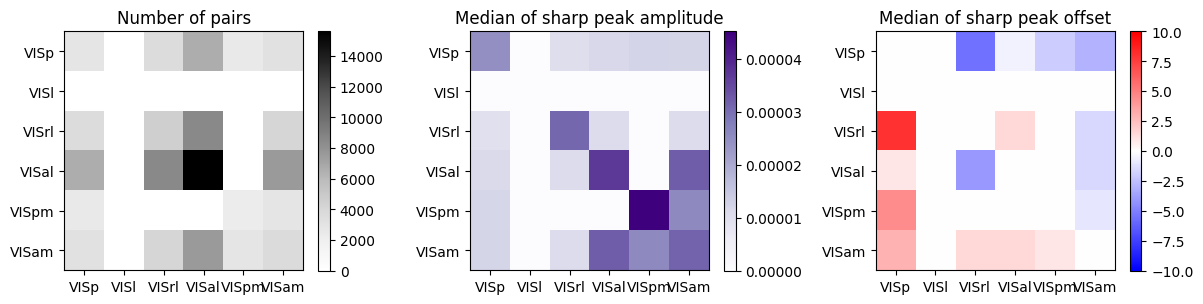

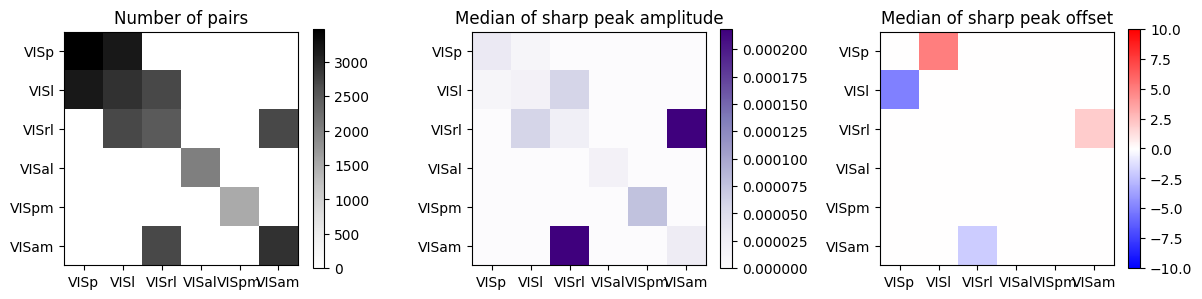

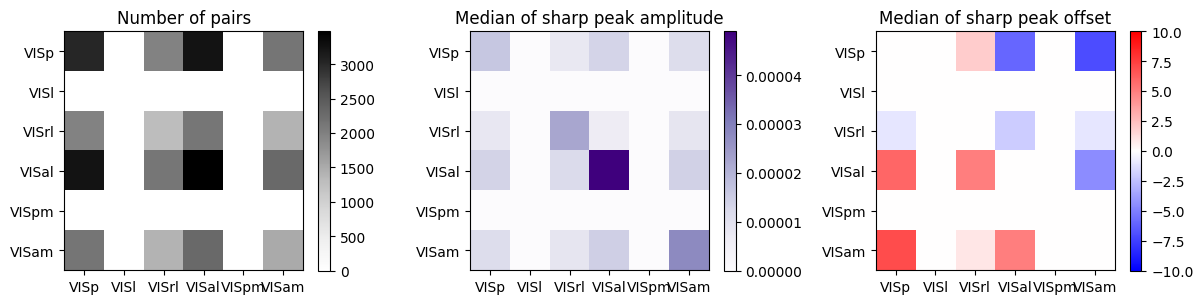

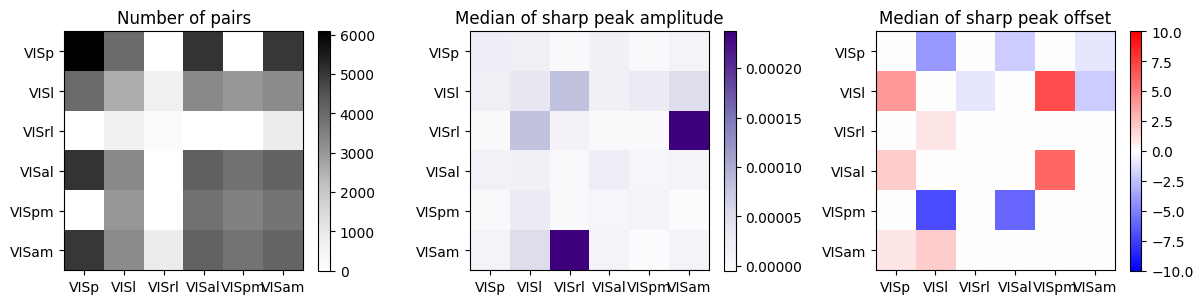

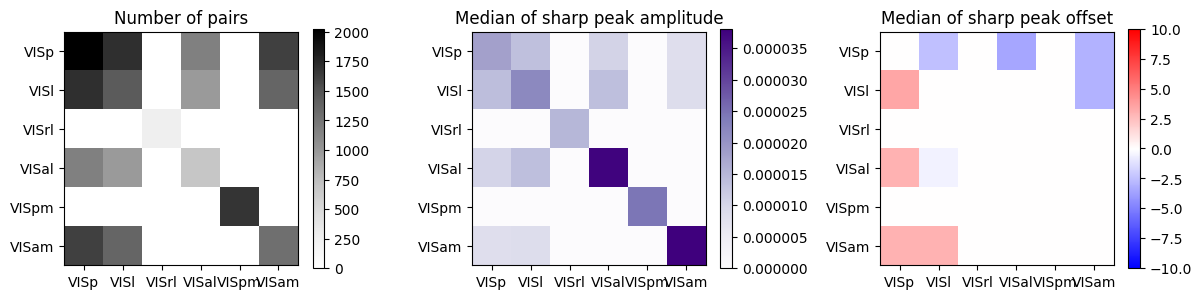

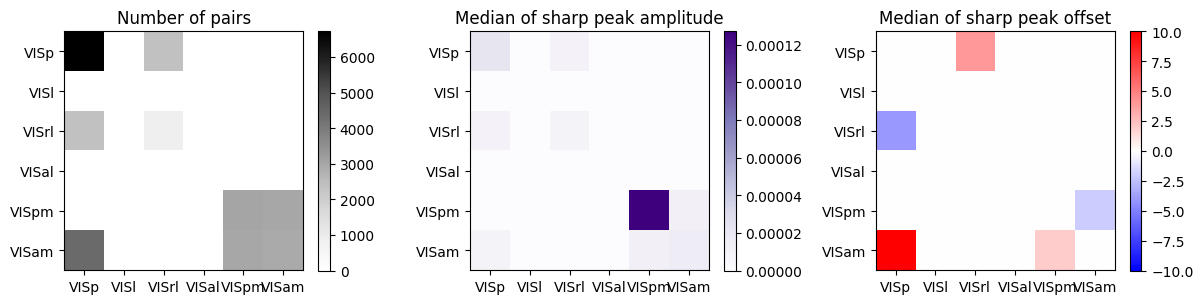

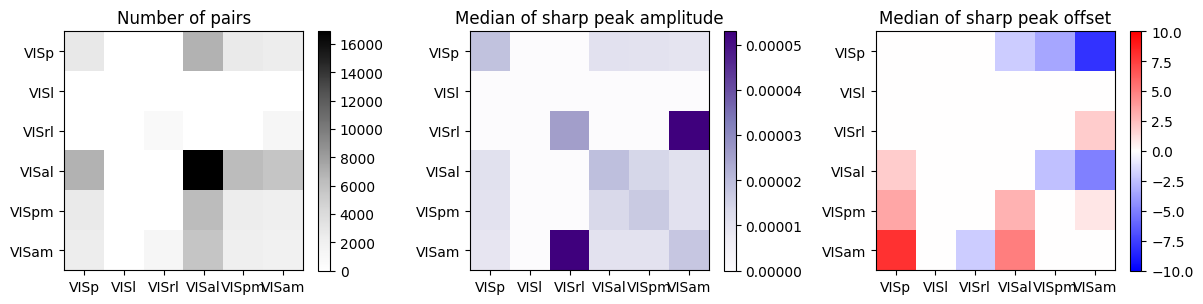

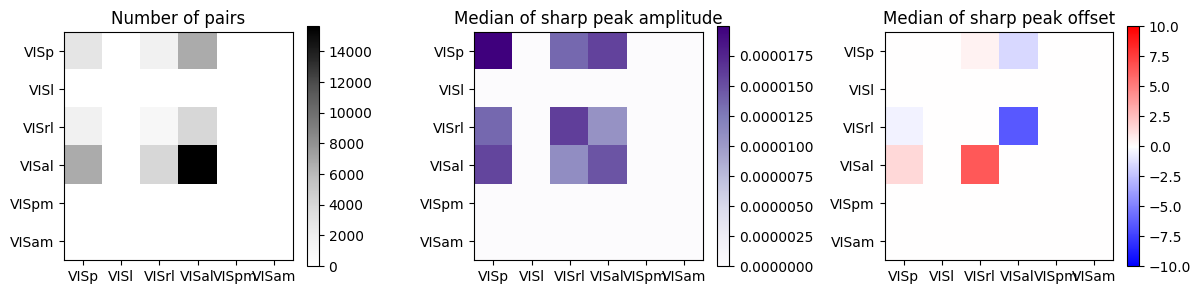

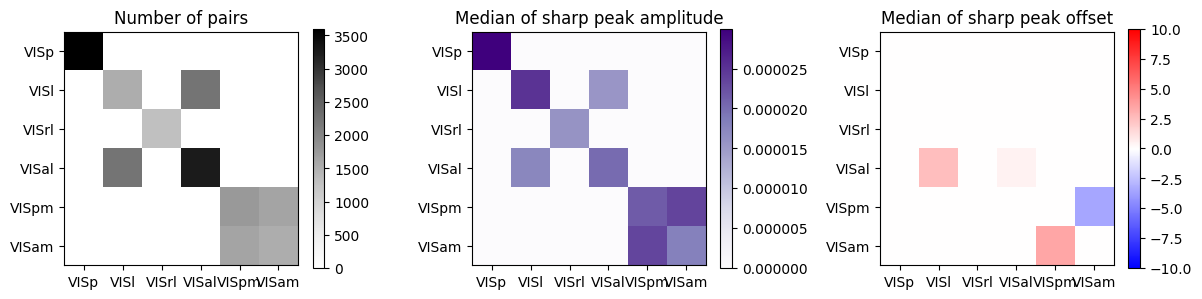

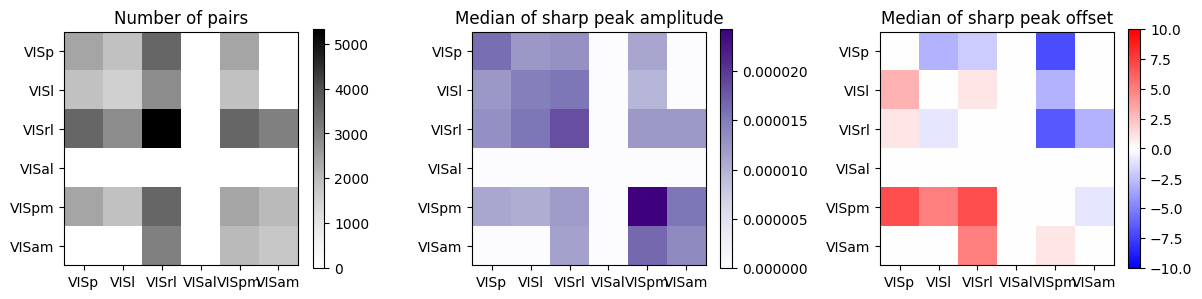

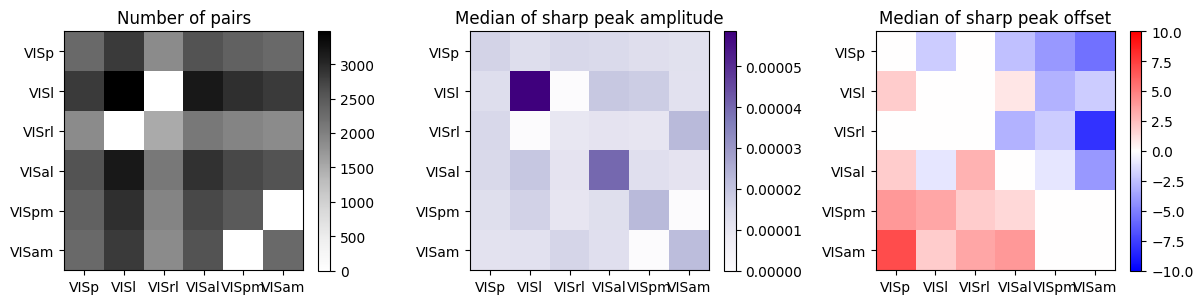

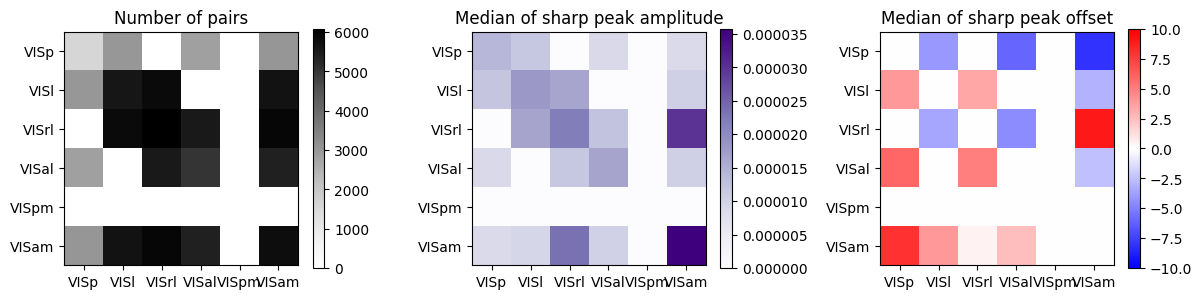

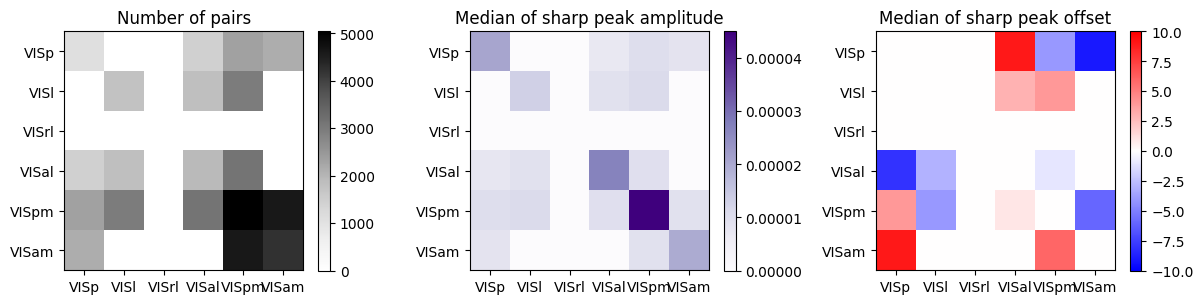

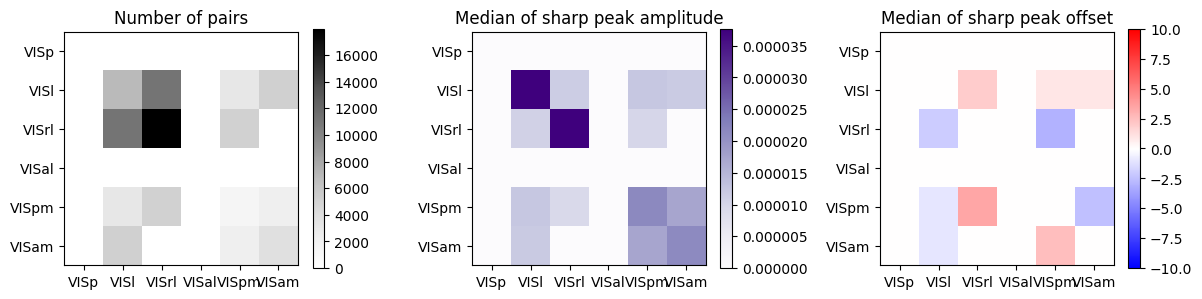

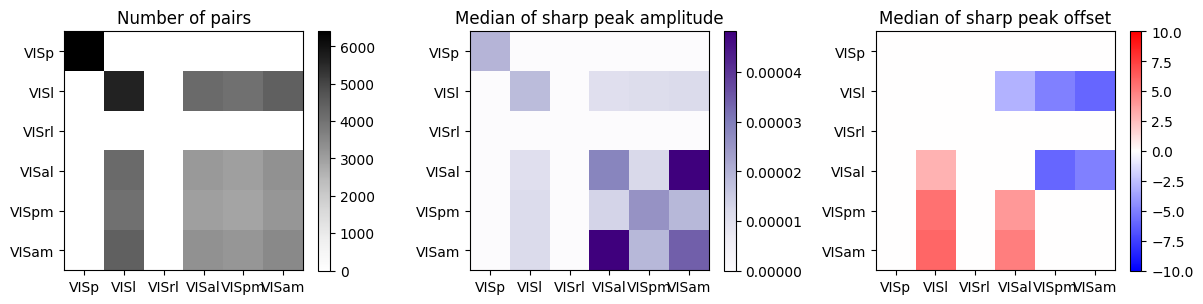

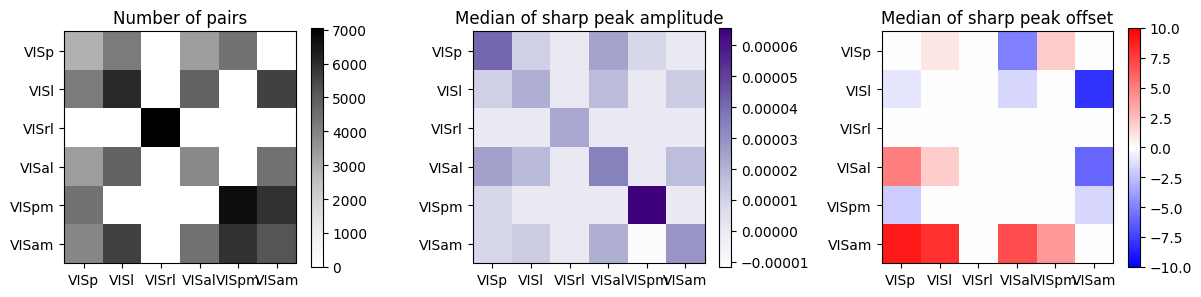

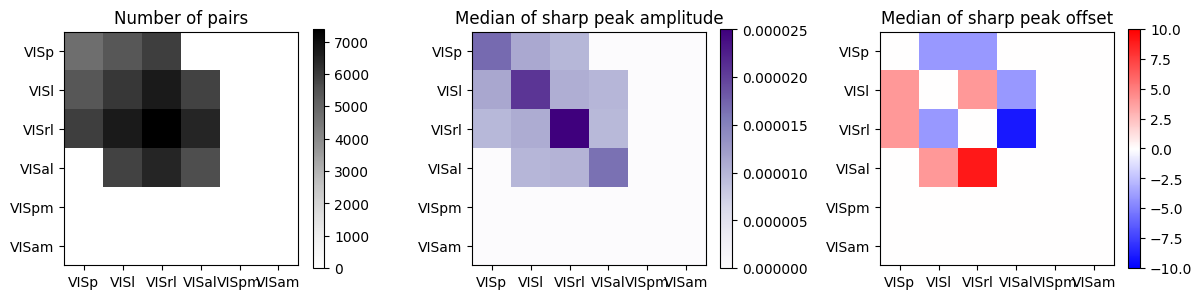

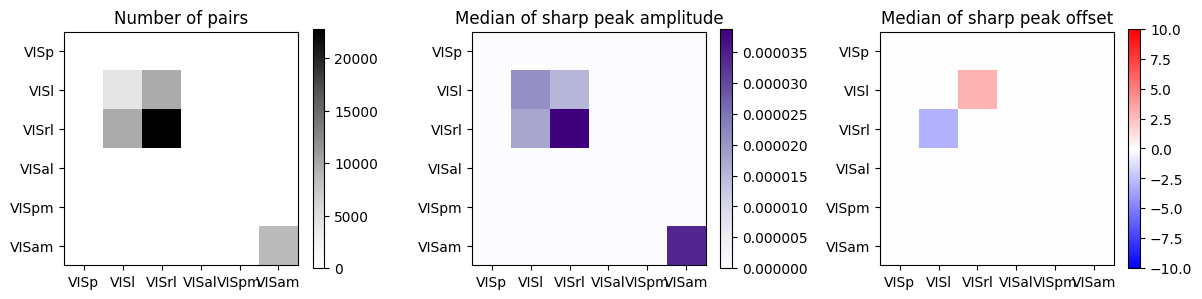

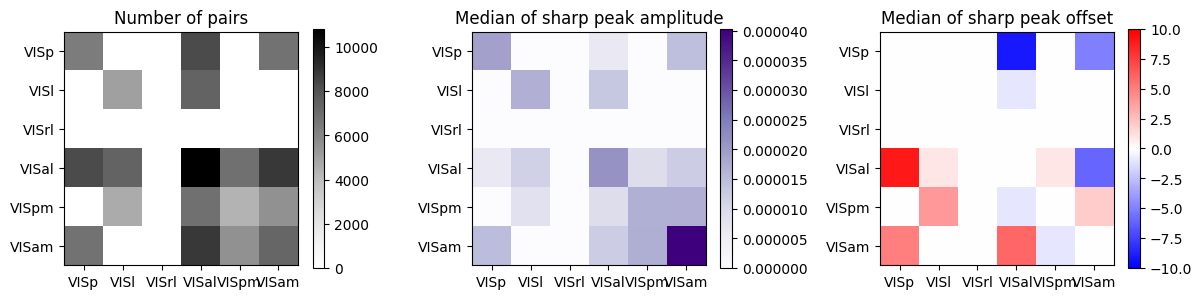

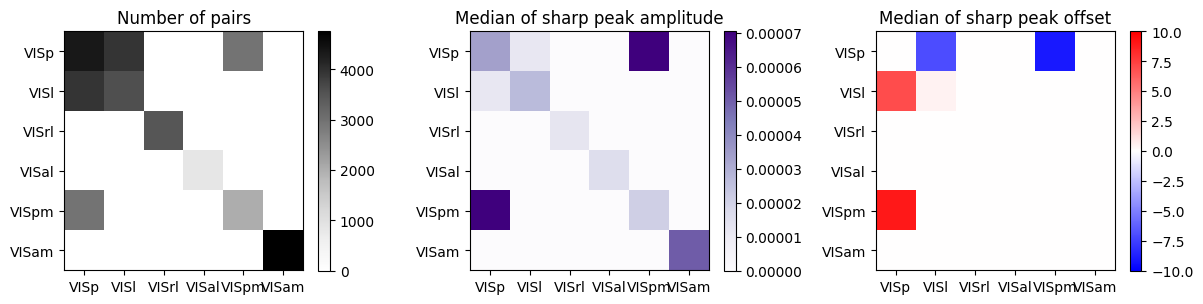

In [5]:
basetype='CCG_grating_full_qc_high'
# load sharp peak with both threshold and window constraints
std=str(7)+str(10)
datatype= std+'std '+basetype

m=len(areas_all)

Verbose = True

mouse_IDs = ['412804', '412809', '415149','416356', '416357',
             '416861','419112', '419114', '419116', 
             '419117', '419118', '419119', '424445',
             '434488','437661','448503',
              '433891', '432105', '432104',
            '437660', '429857', '434494',
            '425597', '415148', '418196']  

N_pair=0
total_pair=0
Count_all = np.zeros((m,m))
COUNT = np.zeros((m,m))
CCG_amp = np.zeros((m,m))
CCG_offset = np.zeros((m,m))
for mouse_ID in mouse_IDs:
    print(mouse_ID)
    basepath = '/Volumes/local1/work_allen/Ephys/resorted/mouse'+mouse_ID

    df = pd.read_csv(basepath+'/matrix/mouse'+mouse_ID+'_all_qc_meta.csv')
    df = df[df.FR>2]

    # add new column with grouped area ids
    areas = ['LGd', #LGN
             'VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'VISmma', #VIS
             'LP','TH', # thalamus
             'MB','MGm', 'MGv', 'MGd', 'APN','Eth','POL','ProS' ,'NOT', 'VPM','RPF','SGN', 'PRE', 'POST', 'SUB', 'HPF', 'ZI', 'IntG', # others
             'DG','CA1', 'CA3', # hippo
             'none'   # not labeled
            ]

    df['areas_group']=np.zeros(len(df))
    for a in areas:
        df['areas_group'][df['ccf'].str.contains(a, case=False, na=False, regex=False)]=a

    ccg_basepath = '/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/CCG_peak/mouse'
    ccg_peak = load_npz(ccg_basepath+mouse_ID+'/ccg_peak_'+datatype+'.npz')
    ccg_peak_idx = load_npz(ccg_basepath+mouse_ID+'/ccg_peak_offset_'+datatype+'.npz')
    assert ccg_peak_idx.shape[0]==len(df)
    # group ccg sharp peak, ccg amplitude, and ccg with areas 
    areas = df.areas_group.unique()
    
    n = len(np.where(ccg_peak_idx.flatten()!=0)[0])
    print(n)
    N_pair+=n
    total_pair+=ccg_peak_idx.shape[0]*ccg_peak_idx.shape[0]-ccg_peak_idx.shape[0]

    count_mouse = np.zeros((m,m))
    count = np.zeros((m,m))
    ccg_amp = np.zeros((m,m))
    ccg_offset = np.zeros((m,m))
    for i, probei in enumerate(areas_all):
        for j, probej in enumerate(areas_all):
            if probei in areas and probej in areas:
                select_idxi = np.where(df.areas_group==probei)[0]
                select_idxj = np.where(df.areas_group==probej)[0]

                # mean amplitude for each pair of areas
                tmp = ccg_peak[select_idxi, :][:, select_idxj].flatten()
                # only consider significant positive connections
                select_peak = np.where(tmp!=0)[0]
                #print(len(select_peak))
                peak = np.nanmean(tmp[select_peak])
                # median peak offset for each pair
                tmp = ccg_peak_idx[select_idxi, :][:, select_idxj].flatten()
                tmp = tmp[select_peak]-99 
                peak_idx = np.nanmedian(tmp)
                
                # put into matrix
                if np.isnan(peak)!=1:
                    count_mouse[i, j]=1
                    count[i, j]=len(select_idxi)*len(select_idxj)
                    ccg_amp[i,j]=peak
                    ccg_offset[i,j]=peak_idx

    # group across mice
    Count_all+=count_mouse
    COUNT+=count
    CCG_amp+=ccg_amp
    CCG_offset+=ccg_offset
    
    if Verbose==True:
        plt.figure(figsize=(16,3))
        plt.subplot(141)
        plt.imshow(count, cmap='Greys')
        plt.xticks(range(m), areas_all)
        plt.yticks(range(m), areas_all)
        plt.title('Number of pairs')
        plt.colorbar()

        plt.subplot(142)
        plt.imshow(ccg_amp, cmap='Purples')
        plt.xticks(range(m), areas_all)
        plt.yticks(range(m), areas_all)
        plt.title('Median of sharp peak amplitude')
        plt.colorbar()

        plt.subplot(143)
        plt.imshow(ccg_offset, cmap='bwr', vmin=-10, vmax=10)
        plt.xticks(range(m), areas_all)
        plt.yticks(range(m), areas_all)
        plt.title('Median of sharp peak offset')
        plt.colorbar()
        plt.tight_layout()


In [6]:
N_pair

56874

In [7]:
total_pair

12908146

In [8]:
N_pair/float(total_pair)

0.004406054905173834

In [9]:
len(mouse_IDs)

25

# plot population summary

In [ ]:
# divide across mice
# number of measured connections
COUNT = COUNT/Count_all
# mean synaptic strength
CCG_amp = np.array(CCG_amp)/np.array(Count_all)
# median of peak offset
CCG_offset = np.array(CCG_offset)/Count_all


Text(0,0.5,'Total Peak offset')

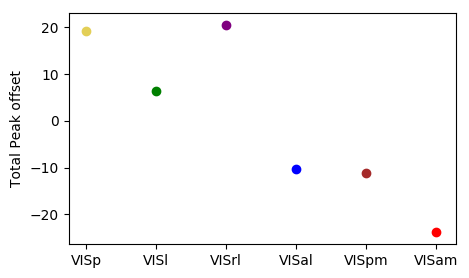

In [29]:
# calculate in/out based on peak offset matrix
plt.figure(figsize=(5,3))
for i in range(m):
    plt.scatter(areas_all[i], np.nansum(CCG_offset, axis=0)[i], c=colors[i])
plt.ylabel('Total Peak offset')
#plt.ylim([-45,45])
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/functional_connectivity/FC_mice27_8area_7std10_resorted_high.pdf')

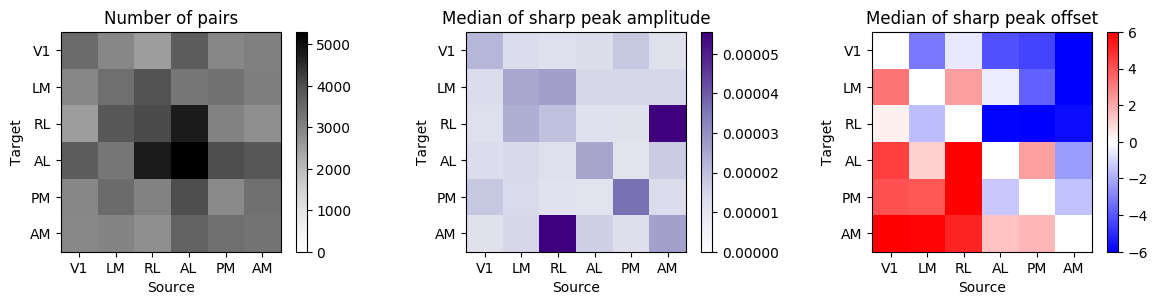

In [30]:
area_names = [ 'V1', 'LM','RL', 'AL',  'PM', 'AM', 'LP']
#area_names = ['V1', 'LM', 'RL','AL',  'PM', 'AM']
plt.figure(figsize=(16,3))
plt.subplot(141)
plt.imshow(COUNT, cmap='Greys', vmin=0)
plt.xticks(range(m), area_names)
plt.yticks(range(m), area_names)
plt.title('Number of pairs')
plt.colorbar()
plt.xlabel('Source')
plt.ylabel('Target')

plt.subplot(142)
plt.imshow(CCG_amp, cmap='Purples', vmin=0)
plt.xticks(range(m), area_names)
plt.yticks(range(m), area_names)
plt.title('Median of sharp peak amplitude')
plt.colorbar()
plt.xlabel('Source')
plt.ylabel('Target')

plt.subplot(143)
plt.imshow(CCG_offset, cmap='bwr', vmin=-6, vmax=6)
plt.xticks(range(m), area_names)
plt.yticks(range(m), area_names)
plt.title('Median of sharp peak offset')
plt.colorbar()
plt.xlabel('Source')
plt.ylabel('Target')
plt.tight_layout()


# histogram of peak offset and peak amplitude at each bin across all mice

In [10]:
basetype='CCG_grating_full_qc_high'
std=str(7)+str(10)
datatype= std+'std '+basetype

#areas_all = ['LGd', 'VISp']
m=len(areas_all)

Verbose = True

mouse_IDs = ['412804', '412809', '415149','416356', '416357','416861','419112', '419114', '419116', 
             '419117', '419118', '419119', '424445',
             '434488','437661','448503',
              '433891', '432105', '432104',
            '437660', '429857', '434494',
            '425597', '415148', '418196']  
# (LGd is after all areas...)
# good mice: 

Count_all = np.zeros((m,m))
COUNT = np.zeros((m,m))
# create empty 2D list
w, h = m, m;
#CCG_amp = [[[] for x in range(w)] for y in range(h)] 
CCG_offset = [[[] for x in range(w)] for y in range(h)] 
LGN = []
for mouse_ID in mouse_IDs:
    #print(mouse_ID)
    basepath = '/Volumes/local1/work_allen/Ephys/resorted/mouse'+mouse_ID

    df = pd.read_csv(basepath+'/matrix/mouse'+mouse_ID+'_all_qc_meta.csv')
    df = df[df.FR>2]

    # add new column with grouped area ids
    areas = ['LGd', #LGN
             'VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'VISmma', #VIS
             'LP','TH', # thalamus
             'MB','MGm', 'MGv', 'MGd', 'APN','Eth','POL','ProS' ,'NOT', 'VPM','RPF','SGN', 'PRE', 'POST', 'SUB', 'HPF', 'ZI', 'IntG', # others
             'DG','CA1', 'CA3', # hippo
             'none'   # not labeled
            ]

    df['areas_group']=np.zeros(len(df))
    for a in areas:
        df['areas_group'][df['ccf'].str.contains(a, case=False, na=False, regex=False)]=a

    ccg_basepath = '/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/CCG_peak/mouse'
    ccg_peak = load_npz(ccg_basepath+mouse_ID+'/ccg_peak_'+datatype+'.npz')
    ccg_peak_idx = load_npz(ccg_basepath+mouse_ID+'/ccg_peak_offset_'+datatype+'.npz')

    # group ccg sharp peak, ccg amplitude, and ccg with areas 
    probenames = df.probe_id.unique().astype(str)

    for i, probei in enumerate(areas_all):
        for j, probej in enumerate(areas_all):
            if probei in areas and probej in areas:
                select_idxi = np.where(df.areas_group==probei)[0]
                select_idxj = np.where(df.areas_group==probej)[0]
                # connection strength
                tmp1 = ccg_peak[select_idxi, :][:, select_idxj].flatten()
                select_peak = np.where(tmp1!=0)[0]
                
                if len(select_peak)>0:
                    peak = np.nanmean(tmp1[select_peak])

                    # ccg amplitude distribution
                    #CCG_amp[i][j] = CCG_amp[i][j]+list(tmp1)

                    # peak offset for each pair
                    tmp = ccg_peak_idx[select_idxi, :][:, select_idxj].flatten()

                    tmp = tmp[select_peak]-100

                    # ccg peak offset distribution
                    CCG_offset[i][j] = CCG_offset[i][j]+list(tmp)


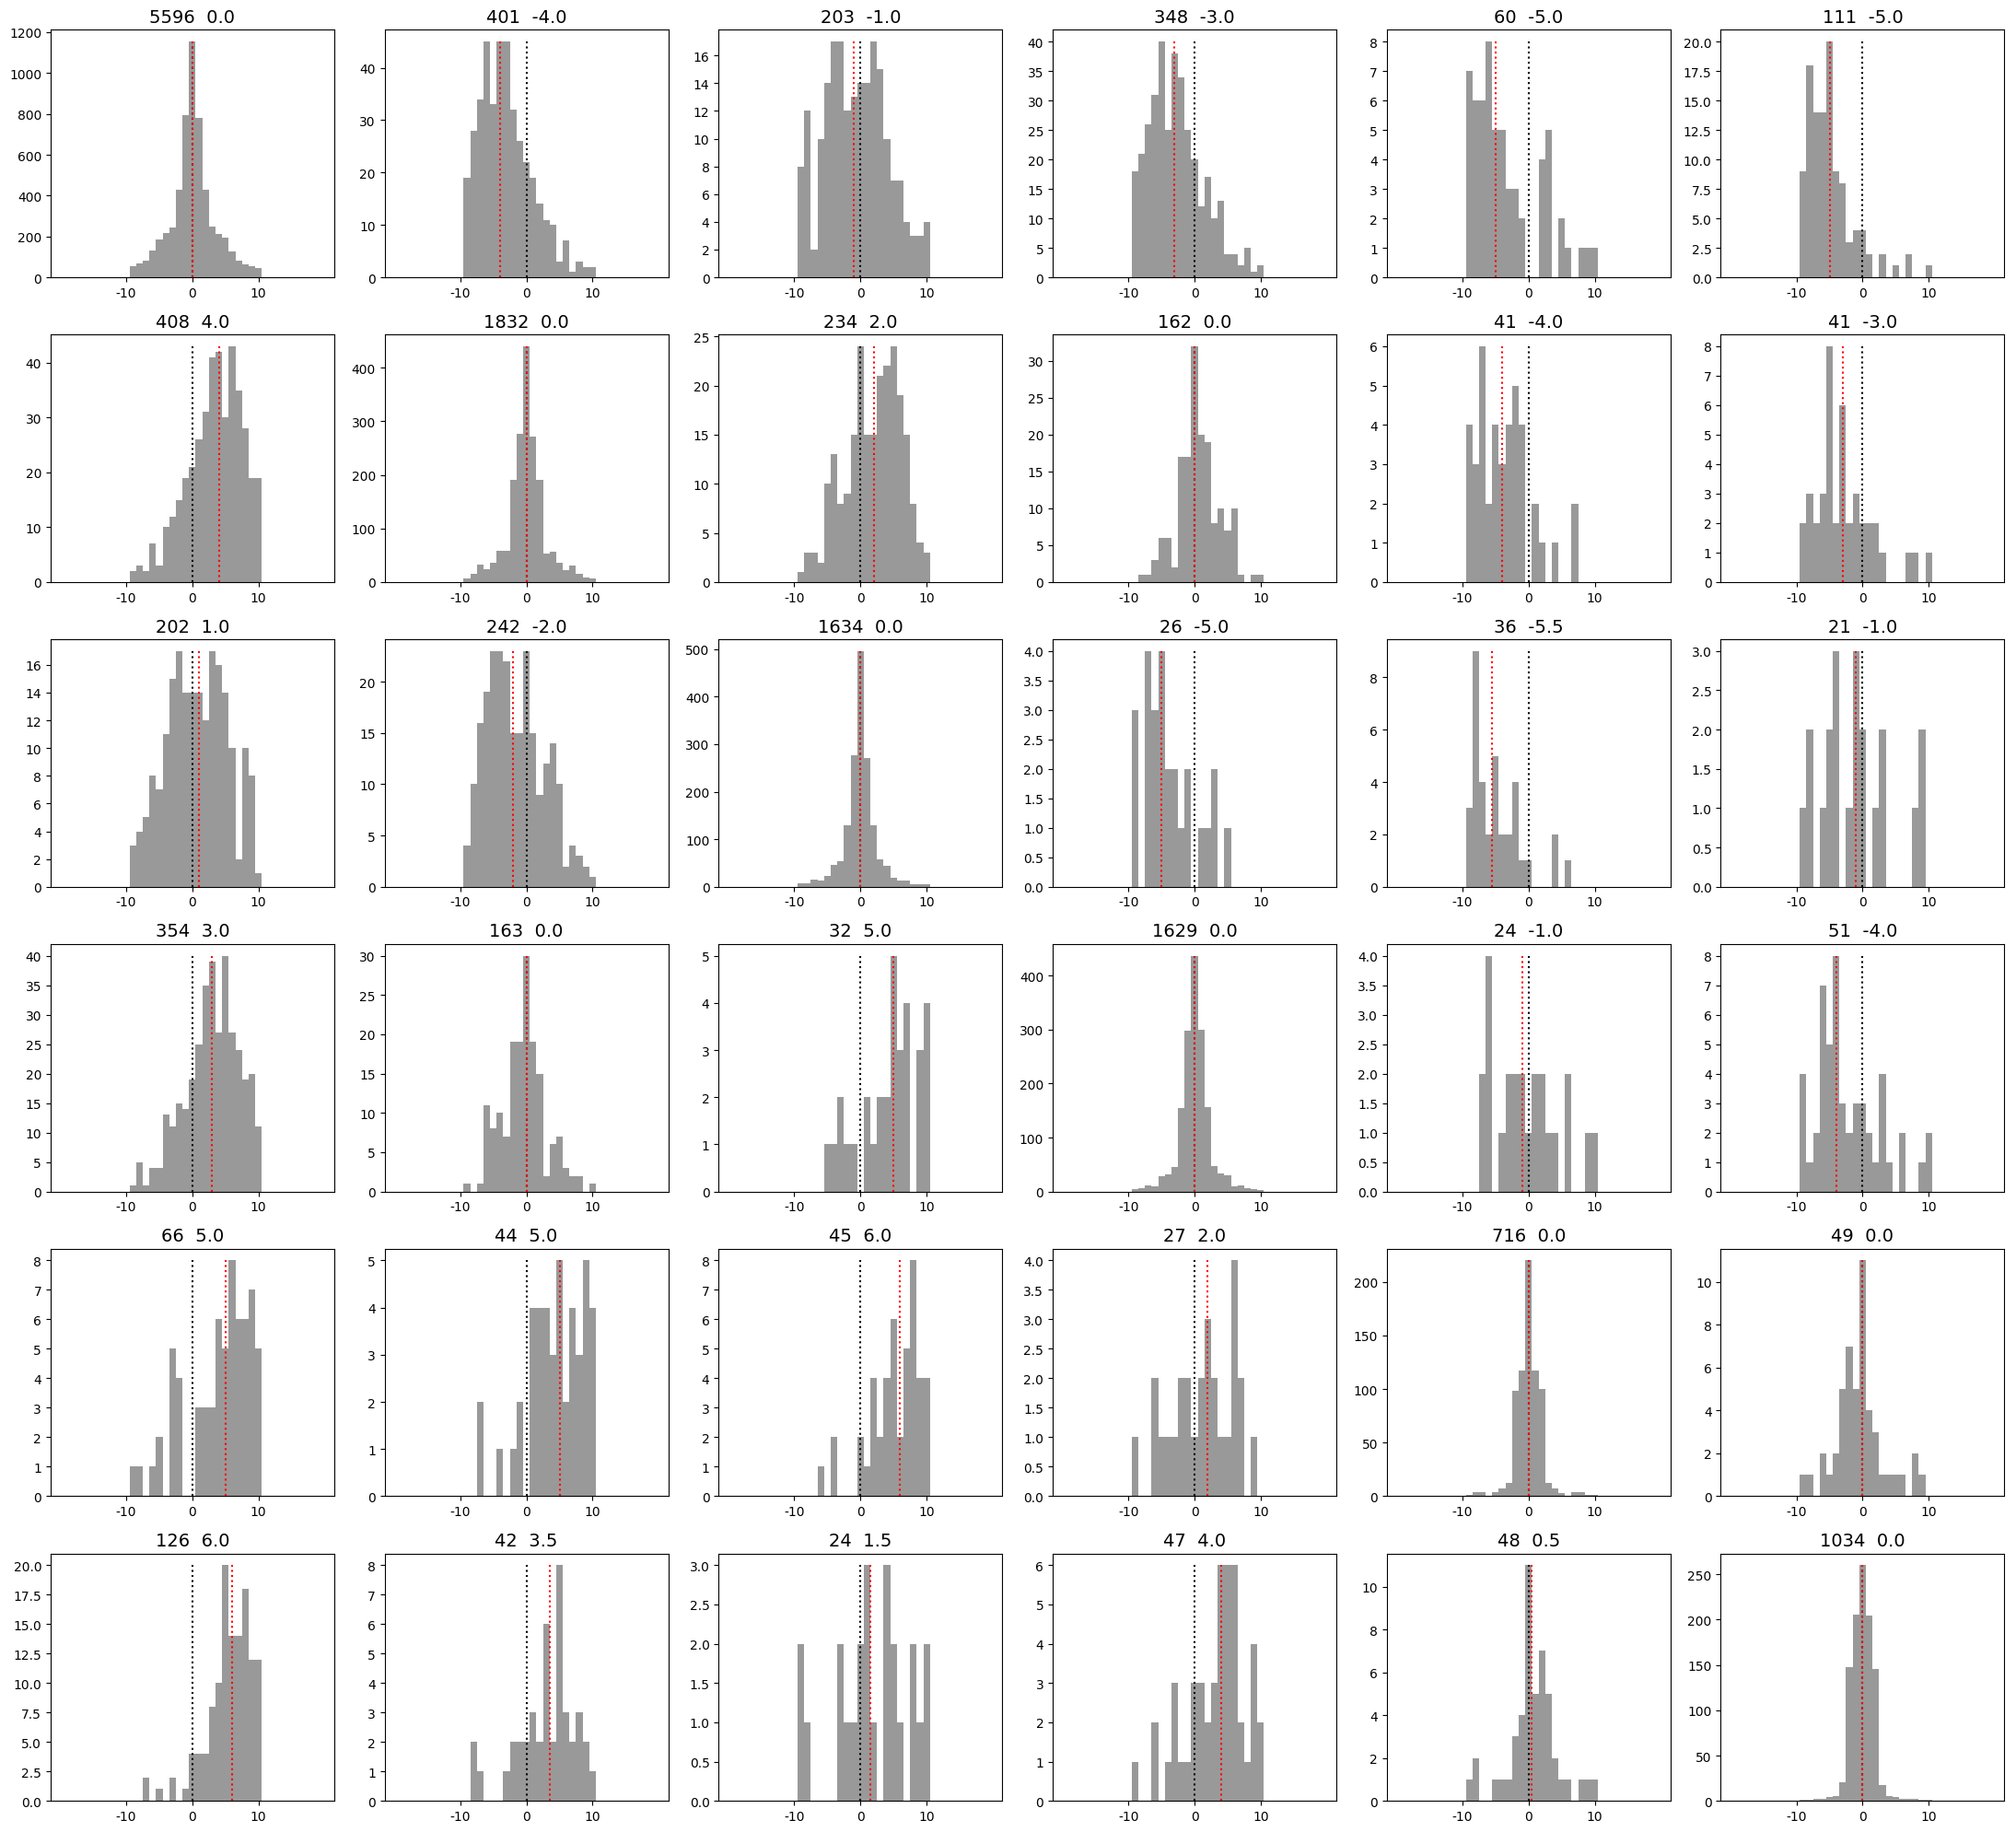

In [11]:
#area_names = ['V1', 'LM', 'RL', 'AL',  'PM', 'AM']
plt.figure(figsize=(22,20))
N_connection=np.zeros((m,m))
M=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        ax1 = plt.subplot(m,m,i*m+j+1)
        a, bins, c = plt.hist(CCG_offset[i][j], bins=np.arange(-20,20,1), color='gray', alpha=0.8)
        #plt.title(areas_all[j]+'-'+areas_all[i], fontsize=15)
        plt.plot([-0.50,-0.50], [0, max(a)], ':k')
        md = round(np.nanmedian(CCG_offset[i][j]), 2)
        plt.plot([md+0.5,md+0.5], [0, max(a)], ':r')
        plt.xticks([-10.5,-0.5,9.5],[-10,0,10])
        plt.title(str(int(sum(a)))+'  '+str(md+1), fontsize=14)
        #plt.title(str(area_names[i])+'-'+str(area_names[j]), fontsize=14)
        N_connection[i,j]=sum(a)
        M[i,j]=md+1
        #ax1.axes.get_yaxis().set_visible(False)
plt.tight_layout()


In [12]:
np.sum(N_connection.flatten())-np.sum(np.diag(N_connection))

3678.0

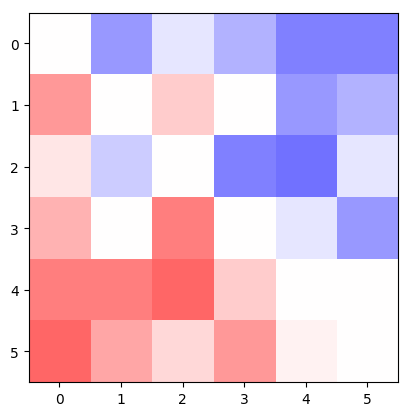

In [13]:
plt.imshow(M, cmap='bwr', vmin=-10, vmax=10)

Text(0,0.5,'Target')

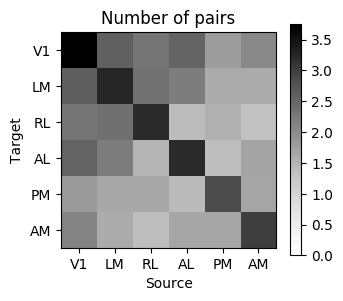

In [14]:
area_names = [ 'V1', 'LM','RL', 'AL',  'PM', 'AM',]
#area_names = ['V1', 'LM', 'RL','AL',  'PM', 'AM']
plt.figure(figsize=(16,3))
plt.subplot(141)
plt.imshow(np.log10(N_connection), cmap='Greys', vmin=0)
plt.xticks(range(6), area_names)
plt.yticks(range(6), area_names)
plt.title('Number of pairs')
plt.colorbar()
plt.xlabel('Source')
plt.ylabel('Target')


# save adjacency matrix with direction

In [31]:
np.save('FC_area_25mice_20_'+std+'std_resorted_high.npy', [COUNT, CCG_amp, CCG_offset])